# 1. Giới thiệu bài toán


<p style="font-size:18px"> Trong bối cảnh sự nóng lên của toàn cầu ảnh hưởng đến khí hậu Trái Đất và sự diễn ra khó lường của các thiên tai, hiện tượng tự nhiên khắc nhiệt, dự báo động đất là một trong những vấn đề quan trọng của khoa học và ngành khí tượng nói chung do những hậu quả, thiệt hại tàn khốc mà chúng gây ra. Những nghiên cứu hiện nay về vấn đề này thường tập trung vào ba yếu tố: diễn ra khi nào, tại khu vực nào và quy mô ra sao. </p>
<p style="font-size:18px"> Trong bài toán này, mục tiêu của chúng ta dự đoán khi động đất xảy ra. Cụ thể là dự đoán khoảng thời gian còn lại trước khi các trận động đất xảy ra từ dữ liệu địa chấn theo thời gian thực. Nếu dự đoán được càng sớm và càng chính xác thì chúng ta sẽ có được những cảnh báo và đưa ra những biễn pháp để giảm thiểu hậu quả, rủi ro và có thể cứu sống rất nhiều người. </p>


# 2. Mô tả dữ liệu


<p style="font-size:18px">
Dữ liệu được sử dụng cho việc huấn luyện mô hình gồm 2 trường trong file csv: <code>train.csv</code>
</p>

<p style="font-size:18px">
    <code>acoustic_data</code>: Đây là dữ liệu địa chấn thu được dựa trên những phương pháp đo thực tế. Là cường độ sóng thu được từ lòng đất với kiểu số nguyên <i>int16</i>.<br>
    <code>time_to_failure</code>: Đây là thời gian mà trận động đất tiếp theo sẽ xảy ra trên thời gian thực tính bằng giây với kiểu số thực <i>float64</i>.
</p>

<p style="font-size:18px"> Trong mỗi lần thử nghiệm, dữ liệu địa chấn hay cường độ sóng và khoảng thời gian còn lại trước khi động đất xảy ra được đo trong 0.0375s (được sắp xếp theo thời gian) và tần số 4MHz (thông tin được cung cấp bởi BTC cuộc thi). Từ đó, ta sẽ có 150000 data points cho mỗi một measurement segment. File <code>train.csv</code> bao gồm 629145480 records tương ứng với khoảng 4194 measurement segments.
</p>
    
<p style="font-size:18px">
<code>test</code>: là một folder bao gồm nhiều file csv, mỗi một file là dữ liệu địa chấn của 1 measurement segment gồm 150000 data points.<br>
Mỗi file test csv ứng với một <code>seg_id</code>, là id của measurement segment tương ứng được thử nghiệm, kết quả của bài toán sẽ là kết quả dự đoán thực hiện trên các <code>seg_id</code> này.
</p>

<p style="font-size:18px">
<code>sample_submission.csv</code>: là mẫu submission file của cuộc thi.
</p>

## 2.1. Chuẩn bị thư viện và đường dẫn

<p style="font-size:18px"> Trước tiên, chúng ta cần import các thư viện, package sẽ sử dụng trong notebook. </p>

In [ ]:
import re
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")

<p style="font-size:18px"> Cài đặt các đường dẫn: </p>

In [ ]:
# path config
test_folder_path = "/kaggle/input/LANL-Earthquake-Prediction/test"
sample_submission_path = "/kaggle/input/LANL-Earthquake-Prediction/sample_submission.csv"
train_path = "/kaggle/input/LANL-Earthquake-Prediction/train.csv"

## 2.2. File train.csv

<p style="font-size:18px"> File train.csv có dung lượng 9.56GB nên thời gian đọc rất lâu và tương đối tốn RAM. Nên chúng ta sử dụng thư viện Pandas để hỗ trợ đọc file CSV thành một dataframe. </p>

In [ ]:
%%time

# create dataframe from csv file
df_train = pd.read_csv(train_path, dtype={"acoustic_data": np.int16, "time_to_failure": np.float64})
df_train.shape

<p style="font-size:18px">Data frame df_train có kích thước (629145480, 2)
. Từ bộ dữ liệu này, chúng ta sẽ cần tạo ra các feature để làm dữ liệu huấn luyện mô hình.<br>
Trong đó, 5 dòng đầu tiên của df_train:
</p>

In [ ]:
df_train.head()

<p style="font-size:18px">Do pandas không thể hiện thị toàn bộ các chữ số sau dấu phẩy, nên ta sẽ hiển thị 10 chữ số sau dấu phẩy của dữ liệu số để thấy được sự thay đổi của trường <code>time_to_failure</code> (thời gian). </p>

In [ ]:
# setting 10 digits for float type
pd.options.display.precision = 11
df_train.head()

## df_train
* <p style="font-size:18px"> Data frame df_train có lượng dữ liệu rất lớn và là dữ liệu thô lấy từ thực nghiệm. </p>
* <p style="font-size:18px"> Field <code>time_to_failure</code> giảm dần theo mỗi record và mỗi  measurement segment.  </p>


## 2.3. File test

In [ ]:
%%time

# create dataframe from first csv test file
df_test = pd.read_csv(test_folder_path + "/seg_00030f.csv", dtype={"acoustic_data": np.int16})
df_test.shape

<p style="font-size:18px"> Các file test sẽ có kích thước (150000, 1) tương đương với 1 measurement segment, do đó phải dự đoán 150000 mốc thời gian <code>time_to_failure</code> cho mỗi data points.
</p>

## test_train
* <p style="font-size:18px"> Dataframe test_train có lượng dữ liệu tương đương với một measurement segment và cần dự đoán về khoảng thời gian còn lại trước khi xảy ra động đất . </p>

# 3. Phân tích dữ liệu 

## 3.1. Kiểm tra tỉ lệ thiếu giá trị với cả 2 datasets df_train và df_test
<p style="font-size:18px"> Ta sẽ sử dụng thư viện <code>matplotlib</code> - thư viện hỗ trợ vẽ và biểu diễn các biểu đồ dữ liệu.<br>
Ở đây chúng ta sẽ tính toán tỉ lệ thiếu giá trị trên mỗi trường của 2 datasets.
</p>

In [ ]:
# calculate missing value percentage and plot
def plot_null_percentage():
    # total null value in both datasets
    null_train_col_1 = df_train["acoustic_data"].isnull().sum()
    null_train_col_2 = df_train["time_to_failure"].isnull().sum()
    null_test = df_test["acoustic_data"].isnull().sum()
    
    # create figure and subplots
    figure, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    figure.set_facecolor("white")
    figure.suptitle("Missing value percentage of train and test datasets")

    # plot in pie
    axs[0].pie([null_train_col_1, len(df_train) - null_train_col_1], labels=["missing", "filled"], explode=(0, 0.01), autopct="%1.1f%%", labeldistance=1.1, startangle=55, colors=["red", "green"])
    axs[0].set_title("df_train: acoustic_data", pad=10)
    axs[1].pie([null_train_col_2, len(df_train) - null_train_col_2], labels=["missing", "filled"], explode=(0, 0.01), autopct="%1.1f%%", labeldistance=1.1, startangle=55, colors=["red", "green"])
    axs[1].set_title("df_train: time_to_failure", pad=10)
    axs[2].pie([null_test, len(df_test) - null_test], labels=["missing", "filled"], explode=(0, 0.01), autopct="%1.1f%%", labeldistance=1.1, startangle=55, colors=["red", "green"])
    axs[2].set_title("df_test: acoustic_data", pad=10)
    plt.show()

In [ ]:
plot_null_percentage()

### Nhận xét
<p style="font-size:18px">
Như vậy, cả 2 datasets đều không có các giá trị null và ta không cần tiến hành fill các giá trị null.
</p>

## 3.2. Sự thay đổi giá trị của acoustic_data và time_to_failure trong 10% dữ liệu
<p style="font-size:18px"> Ở đây ta sẽ biểu diễn đồng thời 2 fields <code>acoustic_data</code> và <code>time_to_failure</code> trên cùng một đồ thị để thấy được sự tương quan giữa chúng.<br>
Chúng ta sẽ xem sét sự thay đổi về giá trị của các fields trong 10% dữ liệu bằng cách sử dụng các slice với bước nhảy 1000, tạo được sự bao quát toàn bộ tập dữ liệu thay vì phải duyệt toàn bộ 629145480 records. </p>

In [ ]:
# plot to see trend of value changing
def plot_value_changing(slice):
    figure, axis_1 = plt.subplots(figsize=(20, 8))
    
    # plot acoustic_data by slice
    plt.title("acoustic_data and time_to_failure value changing in {}% datapoints".format(slice // 100))
    plt.plot(df_train["acoustic_data"].values[::slice], color="orange")
    axis_1.set_ylabel("acoustic_data")
    plt.legend(["acoustic_data"], loc="upper left")

    # duplicate plot and apply to time_to_failure
    axis_2 = axis_1.twinx()
    plt.plot(df_train["time_to_failure"].values[::slice], color="green")
    axis_2.set_ylabel("time_to_failure")
    plt.legend(["time_to_failure"], loc="upper right")

    plt.show()

In [ ]:
plot_value_changing(1000)

### Nhận xét
<p style="font-size:18px"> Ta có thể thấy mỗi lần <code>time_to_failure</code> có giá trị 0 đồng thời giá trị của <code>acoustic_data</code> cũng có sự thay đổi lớn, tại các mốc này đã xảy ra động đất.<br>
Ngoài ra, ta có thể đặt giả thuyết trong toàn bộ dataset có 16 lần xảy ra động đất. Giả thuyết này cũng đúng với 1% dữ liệu.</p>


In [ ]:
plot_value_changing(100)

## 3.3. Sự thay đổi giá trị của time_to_failure và acoustic_data trong khoảng 10 triệu data points đầu
<p style="font-size:18px"> Tiếp theo, chúng ta sẽ xem xét trong 10 triệu dữ liệu đầu tiên sẽ có bao nhiêu lần xảy ra động đất và xu hướng thay đổi giá trị của các field ra sao. </p>

In [ ]:
# plot to see trend of value changing in first 10 million datapoints
def plot_10m_value_changing():
    figure, axis_1 = plt.subplots(figsize=(20,10))
    axis_1.plot(df_train.index.values[:10000000], df_train["acoustic_data"].values[:10000000], color="orange")
    axis_1.set_ylabel("acoustic_data")
    plt.legend(["acoustic_data"], loc="upper left")

    axis_2 = axis_1.twinx()
    axis_2.plot(df_train.index.values[:10000000], df_train["time_to_failure"].values[:10000000], color="green")
    axis_2.set_ylabel("time_to_failure")
    plt.legend(["time_to_failure"], loc="upper right")

    plt.show()

In [ ]:
plot_10m_value_changing()

<p style="font-size:18px"> Ngoài ra, ta cũng sẽ tiến hành xem xét một số chi tiết về dữ liệu của dataset. </p>

In [ ]:
df_train[:10000000].describe()

<p style="font-size:18px"> Sự phân bố của <code>acoustic_data</code> như sau:
</p>

In [ ]:
# acoustic_data distribution in first 10 million datapoints
df_train["acoustic_data"][:10000000].hist(bins=30, range=[-15,15], align="mid")
plt.title("acoustic_data distribution")
plt.xlabel("acoustic data")
plt.show()

### Nhận xét

<p style="font-size:18px"> Như vậy, ta thấy được trong 10 triệu data points ta có duy nhất một lần xảy ra động đất. <br>
Ngoài ra, ta có thể khẳng định được giả thuyết đã nêu ở mục 3.2, trước khi trận động đất xảy ra tức khởi điểm <code>time_to_failure</code> đạt 0 thì biên độ dao động của giá trị địa chấn <code>acoustic_data</code> tăng đột biến.<br>
Sau đó là một khoảng thời gian ít xảy ra thay đổi lớn về giá trị cho tới lần động đất kế tiếp.<br>
Trong 10 triệu data points, giá trị <code>acoustic_data</code> phần lớn tập trung tại khoảng 0 - 10. Ta có thể dùng dữ kiện này làm cơ sở để loại bỏ các giá trị gây nhiễu. </p>
</p>


## 3.4. Sự thay đổi của time_to_failure trong measurement segment đầu

<p style="font-size:18px"> Ta sẽ xem xét sự thay đổi giá trị <code>time_to_failure</code> của 150000 điểm dữ liệu đầu, tương ứng với measurement segment đầu tiên.</p>

In [ ]:
# plot to see trend of value changing in a specific slice
def plot_time_to_failure(slice):
    plt.plot(df_train.index.values[:slice], df_train["time_to_failure"].values[:slice], color="green")
    plt.ylabel("time_to_failure")
    plt.title("time_to_failure in {} data points".format(slice))
    plt.show()

In [ ]:
plot_time_to_failure(150000)

<p style="font-size:18px"> Ta sẽ khảo sát sự thay đổi trên 1 slice nhỏ hơn.</p>

In [ ]:
plot_time_to_failure(10000)

<p style="font-size:18px"> Nhận thấy trên mỗi khoảng 4000 data points, <code>time_to_failure</code> có xu hướng giảm theo một đường tuyến tính.</p>

In [ ]:
plot_time_to_failure(4000)

### Nhận xét
<p style="font-size:18px"> Qua đây ta có thể thấy, sự thay đổi của <code>time_to_failure</code> là không đều nhau. <br> Đồng thời, giá trị của time_to_failure trên mỗi 4000 data points có xu hướng giảm tuyến tính.</p>


## 3.5. Dữ liệu trong các file test

<p style="font-size:18px"> Tiếp theo, ta sẽ biểu diễn dữ liệu của một số file test để kiểm tra xem <code>seg_id</code> đó có xảy ra động đất hay không. </p>

In [ ]:
# plot data in csv test files
def plot_test_file(test_files):
    figure, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))
    for i in range(len(test_files)):
        segment = pd.read_csv(test_folder_path  + "/" + test_files[i])
        axs[i].plot(segment["acoustic_data"].values, color="green")
        axs[i].set_ylabel("acoustic_data")
        axs[i].set_title("test: " + test_files[i])
    
    plt.show()

In [ ]:
plot_test_file(["seg_00030f.csv", "seg_063865.csv", "seg_0c12cc.csv"])

## Nhận xét:
<p style="font-size:18px"> Như vậy, mỗi file hay mỗi <code>seg_id</code> là một segment gồm 150000 data points. Như 3 biểu đồ ở trên, ta có thể thấy cả 3 <code>seg_id</code> này đều có xảy ra động đất do biên độ dao động của <code>acoustic_data</code> là rất lớn.</p>

# 4. Features Generation

<p style="font-size:18px">Đây là quá trình tạo ra thêm các features mới từ một hoặc các features hiện có, có khả năng sử dụng trong quá trình dự đoán và xây dựng mô hình. Đối với bài toán này, feature được cung cấp chỉ có duy nhất một nên ta sẽ phải tạo thêm các features mới từ field <code>acoustic_data</code>.</p>

<p style="font-size:18px"> Do lượng data rất lớn, lên đến hơn 600 triệu data points, nên chúng ta sẽ chia nhỏ data thành các measurement segments với size là 150000 tương ứng với lượng records của một file test hay một <code>seg_id</code>.</p>

In [ ]:
rows = df_test.shape[0]                                 # total records of 1 test file/seg_id
segments = int(np.floor(df_train.shape[0] / rows))      # total measurement segments in df_train
print("Number of segments: ", segments)

<p style="font-size:18px"> Như vậy, dataframe df_train có tất cả 4194 segments. Tiếp theo, ta sẽ khởi tạo giá trị x_train và y_train. Trong đó số lượng index là số lượng segments, y_train có 1 cột field dữ liệu là <code>time_to_failure</code> còn các features của x_train sẽ được khởi tạo từ field <code>acoustic_data</code>.</p>

In [ ]:
# create x_train and y_train dataframe
x_train = pd.DataFrame(index=range(segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=["time_to_failure"])

### Nhận xét
<p style="font-size:18px"> <code>acoustic_data</code> là dữ liệu thô thu được từ máy đo cường độ sóng địa chất từ lòng đất, như vậy ta không thể sử dụng field này như một feautre để huấn luyện mô hình.<br>
Vì vậy, chúng ta phải tạo ra các features mới từ <code>acoustic_data</code> và lựa chọn features phù hợp để sử dụng cho quá trình huấn luyện mô hình.<br>
Các features sẽ được khởi tạo bao gồm những features về số liệu cơ bản như mean (trung bình), std (độ lệch chuẩn), quantile (lượng tử/phân vị), skew (tính bất đối xứng của phân phối xác suất), v.v của mỗi segment hoặc của một số slice nhất định. Ngoài ra ta tạo thêm các features bằng cách biến đổi dữ liệu từ miền thời gian về miền tần số với thuật toán FFT (Fast Fourier Transform). <br>
<br>Sau khi tạo thêm các features, chúng ta sẽ cần phải xem xét các biểu đồ dữ liệu để đánh giá tính phù hợp của các features đó.
</p>

In [ ]:
def generate_feature(df, x, seg):
#     series_x = pd.Series(seg["acoustic_data"].values)
    
    df.loc[seg, "mean"] = x.mean() 
    df.loc[seg, "mean_abs"] = np.abs(x).mean() # normal mean might be around 0 values

    df.loc[seg, "std"] = x.std()
    df.loc[seg, "std_abs"] = np.abs(x).std()
    df.loc[seg, "std_first_10000"] = x[:10000].std()
    df.loc[seg, "std_last_10000"]  =  x[-10000:].std()
    df.loc[seg, "std_first_50000"] = x[:50000].std()
    df.loc[seg, "std_last_50000"]  =  x[-50000:].std()

    df.loc[seg, "max"] = x.max()
    df.loc[seg, "max_abs"] = np.abs(x).max()

    df.loc[seg, "min"] = x.min()
    df.loc[seg, "min_abs"] = np.abs(x).min()

    df.loc[seg, "sum"] = x.sum()

    df.loc[seg, "mad"] = x.mad() # mean absolute deviation
    df.loc[seg, "skew"] = x.skew()
        
    df.loc[seg, "quant_01"] = np.quantile(x,0.01)
    df.loc[seg, "quant_01_abs"] = np.quantile(np.abs(x), 0.01)
    df.loc[seg, "quant_05"] = np.quantile(x,0.05)
    df.loc[seg, "quant_05_abs"] = np.quantile(np.abs(x), 0.05)
    df.loc[seg, "quant_95"] = np.quantile(x,0.95)
    df.loc[seg, "quant_95_abs"] = np.quantile(np.abs(x), 0.95)
    df.loc[seg, "quant_99"] = np.quantile(x,0.99)
    df.loc[seg, "quant_99_abs"] = np.quantile(np.abs(x), 0.99)
    
    # compute the q-th percentile of the data
    df.loc[seg, "q_10"] = np.percentile(x, 0.10)
    df.loc[seg, "q_25"] = np.percentile(x, 0.25)
    df.loc[seg, "q_50"] = np.percentile(x, 0.50)
    df.loc[seg, "q_75"] = np.percentile(x, 0.75)
    df.loc[seg, "q_90"] = np.percentile(x, 0.90)
    
    # fft
    fft = np.fft.fft(x)
    real_fft = np.real(fft)
    imag_fft = np.imag(fft)
    df.loc[seg, "real_mean"] = real_fft.mean()
    df.loc[seg, "real_std"] = real_fft.std()
    df.loc[seg, "real_max"] = real_fft.max()
    df.loc[seg, "real_min"] = real_fft.min()
    df.loc[seg, "real_mean_last_5000"] = real_fft[-5000:].mean()
    df.loc[seg, "real_std_last_5000"] = real_fft[-5000:].std()
    df.loc[seg, "real_max_last_5000"] = real_fft[-5000:].max()
    df.loc[seg, "real_min_last_5000"] = real_fft[-5000:].min()
    df.loc[seg, "real_mean_last_15000"] = real_fft[-15000:].mean()
    df.loc[seg, "real_std_last_15000"] = real_fft[-15000:].std()
    df.loc[seg, "real_max_last_15000"] = real_fft[-15000:].max()
    df.loc[seg, "real_min_last_15000"] = real_fft[-15000:].min()

    df.loc[seg, "imag_mean"] = imag_fft.mean()
    df.loc[seg, "imga_std"] = imag_fft.std()
    df.loc[seg, "imga_max"] = imag_fft.max()
    df.loc[seg, "imag_min"] = imag_fft.min()
    
    # features generation using rolling
    for w in [10, 100, 1000, 10000]:
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_min = x.rolling(w).min().dropna().values
        x_roll_max = x.rolling(w).max().dropna().values
        x_roll_mean = x.rolling(w).max().dropna().values
        
        df.loc[seg, "mean_roll_std_" + str(w)] = x_roll_std.mean()
        df.loc[seg, "mean_roll_abs_mean_" + str(w)] = x_roll_abs_mean.mean()
        df.loc[seg, "mean_roll_mean_" + str(w)] = x_roll_mean.mean()

        df.loc[seg, "std_roll_std_" + str(w)] = x_roll_std.std()
        df.loc[seg, "std_roll_max_" + str(w)] = x_roll_max.std()
        df.loc[seg, "std_roll_mean_" + str(w)] = x_roll_mean.std()
        df.loc[seg, "std_roll_abs_mean_" + str(w)] = x_roll_abs_mean.std()
        df.loc[seg, "std_roll_min_" + str(w)] = x_roll_min.std()

        df.loc[seg, "max_roll_std_" + str(w)] = x_roll_std.max()
        df.loc[seg, "max_roll_mean_" + str(w)] = x_roll_mean.max()
        df.loc[seg, "max_roll_min_" + str(w)] = x_roll_min.max()
        df.loc[seg, "min_roll_mean_" + str(w)] = x_roll_mean.min()
        df.loc[seg, "min_roll_std_" + str(w)] = x_roll_std.min()
        df.loc[seg, "min_roll_max_" + str(w)] = x_roll_max.min()

        df.loc[seg, "quant_01_roll_std_" + str(w)] = np.quantile(x_roll_std, 0.01)
        df.loc[seg, "quant_05_roll_std_" + str(w)] = np.quantile(x_roll_std, 0.05)
        df.loc[seg, "quant_10_roll_std_" + str(w)] = np.quantile(x_roll_std, 0.10)
        df.loc[seg, "quant_95_roll_std_" + str(w)] = np.quantile(x_roll_std, 0.95)
        df.loc[seg, "quant_99_roll_std_" + str(w)] = np.quantile(x_roll_std, 0.99)
        df.loc[seg, "quant_05_roll_mean_" + str(w)] = np.quantile(x_roll_mean, 0.05)
        df.loc[seg, "quant_95_roll_mean_" + str(w)] = np.quantile(x_roll_mean, 0.95)
        df.loc[seg, "quant_05_roll_abs_mean_" + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        df.loc[seg, "quant_95_roll_abs_mean_" + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        df.loc[seg, "quant_05_roll_min_" + str(w)] = np.quantile(x_roll_min, 0.05)
        df.loc[seg, "quant_95_roll_min_" + str(w)] = np.quantile(x_roll_min, 0.95)
        df.loc[seg, "quant_05_roll_max_" + str(w)] = np.quantile(x_roll_max, 0.05)
        df.loc[seg, "quant_95_roll_max_" + str(w)] = np.quantile(x_roll_max, 0.95)
    return df

<p style="font-size:18px"> Ta sẽ tiến hành khởi tạo các features cho x_train bằng cách khởi tạo features lần lượt trên từng segment bằng func <code>generate_feature</code> ở trên. </p>

In [ ]:
# generate features for each measurement segments
for segment in tqdm(range(segments)):
    seg = df_train.iloc[segment * rows: segment * rows + rows]
    x = pd.Series(seg["acoustic_data"].values)
    y = seg["time_to_failure"].values[-1]
    y_train.loc[segment, "time_to_failure"] = y
    x_train = generate_feature(x_train, x, segment)

<p style="font-size:18px"> x_train sau khi đã được khởi tạo thêm các features. </p>

In [ ]:
x_train.head()

<p style="font-size:18px"> Mô tả về x_train. </p>

In [ ]:
x_train.describe()

<p style="font-size:18px"> Tiếp theo, chúng ta sẽ biểu diễn sự tương quan giữa 2 tập này. Func <code>plot_feature</code> được sử dụng để mô tả sự tương quan của từng feature của x_train so với y_train. Feature nào không phù hợp hoặc không cần thiết cho các quá trình tiếp theo thì chúng ta sẽ loại bỏ để tránh gây nhiễu mô hình . </p>

In [ ]:
# plot all generated features
def plot_feature(feature, x=x_train):
    fig, axs = plt.subplots(figsize=(20, 8)) 
    axs.set_xlabel(feature)
    axs.set_ylabel("time_to_failure")
    plt.title("{} - time_to_falure".format(feature))
    plt.scatter(x=x[feature], y=y_train, color="green")
    plt.show()

In [ ]:
for feature in x_train.columns:
    plot_feature(feature)

# 5. Xử lý dữ liệu cho training và testing data

## 5.1. Training data

<p style="font-size:18px"> Trước hết ta sẽ loại bỏ các features có đồ thị chỉ có giá trị 0 như <code>min_abs</code> và <code>quant_01_abs</code>.</p>

In [ ]:
x_train = x_train.drop(columns=["min_abs", "quant_01_abs"])

<p style="font-size:18px"> Ngoài ra các features có đồ thị không biểu diễn được thông tin gì đặc biệt, không phải dạng linear cũng không phải non-linear nên ta cũng sẽ loại bỏ những features này để không làm nhiễu mô hình dữ liệu. </p>

In [ ]:
# drop useless features
x_train = x_train.drop(columns=["sum", "mean", "mean_roll_mean_10", 
                                "mean_roll_mean_100", "mean_roll_mean_10000", 
                                "min_roll_std_100", "mean_roll_mean_1000", 
                                "quant_05_roll_abs_mean_1000", "quant_05_roll_abs_mean_100", 
                                "quant_05_roll_mean_10000", "quant_95_roll_mean_10000", 
                                "quant_05_roll_abs_mean_10000"])

<p style="font-size:18px"> Dataframe x_train sau khi loại bỏ các features gây nhiễu sẽ có size là (4194, 138), trong đó 4194 records tương ứng với 4194 measurement segments và 138 features. </p>

In [ ]:
x_train

### Nhận xét
<p style="font-size:18px"> Các features được tạo ra trên nhiều miền giá trị khác nhau (thời gian, tần số, ...), do đó ta sẽ chuẩn hoá, biến đổi những features này về cùng một miền giá trị. Cũng như loại bỏ các giá trị trung bình và chia tỷ lệ theo phương sai đơn vị. Điều đó sẽ giúp cho các dữ liệu huấn luyện và test thuộc cùng một miền giá trị,có lợi hơn cho mô hình trong quá trình học và dự đoán kết quả.<br
>
Ở đây ta sẽ sử dụng <code>StandardScaler</code> để thực hiện việc chuẩn hóa.</p>

In [ ]:
# standardize
scaler = StandardScaler()
scaler.fit(x_train)
scaled_x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)

<p style="font-size:18px"> Dataframe x_train sau khi đã được chuẩn hoá.  </p>

In [ ]:
scaled_x_train

## 5.2. Testing data

<p style="font-size:18px"> Các file csv trong folder test từ data của cuộc thi dùng để submit kết quả cho bài toán. <br>
Ta sẽ dọc file <code>sample_submission.csv</code> và từ đó tạo dataframe x_test có cấu trúc, số cột bằng với số cột của x_train, số hàng tương ứng với số file csv trong folder test. <br>
Dữ liệu từ mỗi file test csv sẽ là 1 record/hàng của dataframe x_test và lặp lại quá trình tạo features từ 150000 datapoints như đã làm với x_train trước đó.
</p>

In [ ]:
submission = pd.read_csv(sample_submission_path, index_col="seg_id")
x_test = pd.DataFrame(columns=scaled_x_train.columns, dtype=np.float64, index=submission.index)

# generate feautres for csv test files
for i in tqdm(x_test.index):
    seg = pd.read_csv(test_folder_path + "/" + i + ".csv")
    x = pd.Series(seg["acoustic_data"].values)
    x_test = generate_feature(x_test, x, i)

<p style="font-size:18px"> Ta cũng sẽ tiến hành loại bỏ những features không dùng tới hoặc gây nhiễu như x_train. </p>

In [ ]:
# drop useless features
x_test = x_test.drop(columns=["sum", "mean", "mean_roll_mean_10", 
                              "mean_roll_mean_100", "mean_roll_mean_10000", 
                              "min_roll_std_100", "mean_roll_mean_1000", 
                              "quant_05_roll_abs_mean_1000", "quant_05_roll_abs_mean_100", 
                              "quant_05_roll_mean_10000", "quant_95_roll_mean_10000", 
                              "quant_05_roll_abs_mean_10000", "min_abs", "quant_01_abs"])

<p style="font-size:18px"> Dataframe x_test: </p>

In [ ]:
x_test

<p style="font-size:18px"> Như vậy, dataframe x_test sẽ có cùng số lượng features với x_train là 138 và có 2624 records tương ứng với số lượng file test csv. Sau đó, ta sẽ tiến hành chuẩn hóa dữ liệu của về cùng một miền giá trị bằng <code>StandardScaler</code> tương tự như đã làm ở trên.</p>

In [ ]:
scaled_x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

<p style="font-size:18px"> x_test sau chuẩn hoá. </p>

In [ ]:
scaled_x_test

# 6.Huấn luyện 


## 6.1. Lựa chọn mô hình

<p style="font-size:18px"> Để huấn luyện cho mô hình, ta sẽ thử với một số mô hình như AdaBoostRegressor, LightGBM và Ridge. Sau đó so sánh các kết quả và lựa chọn mô hình thích hợp nhất hoặc sử dụng <code>VotingRegressor</code> để tạo ra mô hình cuối cùng.<br>
<br>
Ta sẽ dùng <code>K-Fold</code> để chia bộ dữ liệu thành các folds (k folds), mỗi fold sẽ được thay phiên sử dụng làm tập test một lần và các folds còn lại sẽ được sử dụng làm tập train.<br> 
Như vậy, ta sẽ đánh giá được chính xác hơn độ khả dụng của mô hình đối với bài toán. Ở đây, chúng ta sẽ chia thành 5 folds, nhiều hơn có thể gây ra tình trạng tràn RAM và crash session đối với một số mô hình.</p>

In [ ]:
# create n folds and rename columns with re
folds = KFold(n_splits=5, shuffle=True, random_state=42)
scaled_x_train = scaled_x_train.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))

<p style="font-size:18px">Ngoài ra, cuộc thi còn đưa ra hàm lỗi <code>mean_absoluted_error</code> để tính điểm khi submit kết quả bài toán, có công thức như sau: <br></p>
<h3><center> $MAE = $$\sum\limits_{x=1}^{n} {\mid y_i - x_i \mid \over n} = $$\sum\limits_{x=1}^{n} {e_i \over n}$ </center></h3>
<p style="font-size:18px">Ở đây chúng ta cũng sẽ sử dụng MAE để so sánh các mô hình. </p>

## 6.2. Mô hình AdaBoostRegressor

<p style="font-size:18px"> AdaBoost (Adaptive Boost) là một thuật toán boosting dùng để xây dựng classifer cho các bài toán phân lớp hoặc regressor cho các bài toán hồi quy. <br>
Boosting là thuật toán học quần thể bằng cách xây dựng nhiều thuật toán học cùng lúc như cây quyết định và kết hợp chúng lại. Mục đích là tạo ra một cụm hoặc một nhóm các weak learner sau đó kết hợp chúng lại để tạo ra một strong learner duy nhất. <br>
<br>
Ý tưởng của AdaBoost xuất phát từ Boosting nhưng nó lại sử dụng toàn bộ dữ liệu để huấn luyện từng mô hình con với trọng số được phân phối lại sau mỗi lần huấn luyện sao cho mô hình sau quan tâm nhiều hơn đến những lỗi sai của mô hình trước đó. <br>
<br>
Mô hình sẽ gán trọng số cho tất cả các điểm dữ liệu:  $\sum\limits_{i}w_i = 1$, $w_i = w_k$ <br>
Với mỗi lần boosting:<br>
- Huấn luyện các mô hình con: $C_i = train(x, y, w)$ <br>
- Dự đoán nhãn: $\hat y = predict(C_j, x)$ <br>
- Tổng lỗi sẽ được tính theo công thức: $\epsilon = \sum\limits_{i} w_i.(\hat y_i! = y_i)$. Tổng lỗi có độ lớn trong khoảng [0, 1], khi tất cả các dự đoán là đúng thì tổng lỗi bằng 0 và ngược lại. <br>
- Hệ số $a_i = 0.5\log{1 - \epsilon \over \epsilon}$. Tượng trưng cho ảnh hưởng của mô hình con thứ i lên toàn bộ mô hình lớn. Khi mô hình con đó có ít dự đoán sai, $\epsilon$ sẽ thấp, do đó mô hình đóng góp nhiều cho dự đoán cuối cùng. <br>
- Cập nhật trọng số: $w = w * \exp(-a_i * \hat y * y)$
</p>

### Cài đặt
<p style="font-size:18px"> Để cài đặt mô hình AdaBoostRegressor, ta sẽ sử dụng thư viện scikit-learn để gọi hàm <code>AdaBoostRegressor()</code>. <br>
Do lượng dữ liệu tương đối lớn, nên chúng ta sẽ sử dụng <code>RandomizedSearchCV</code> với một số bộ params để điều chỉnh tham số cho quá trình huấn luyện và dự đoán kết quả. Từ đó có được estimator tốt nhất.
</p>

In [ ]:
# params
params = {"n_estimators": [50, 100],
          "learning_rate": [0.01, 0.05, 0.1, 0.2],
          "loss": ["linear", "square", "exponential"]}

random_ada = RandomizedSearchCV(AdaBoostRegressor(), param_distributions=params, cv=folds, n_iter=10, n_jobs=-1, scoring="neg_mean_absolute_error", verbose=1)

# get result
result = random_ada.fit(scaled_x_train, y_train.values.ravel())

print("Best MAE score: {}".format(-result.best_score_))
print("Best params: {}".format(result.best_params_))

## 6.3. Mô hình LightGBM Regressor

<p style="font-size:18px"> LightGBM là một framework để xử lý thuật toán tăng cường độ dốc (Gradient Boosting) do Microsoft phát triển.<br> 
<br>
Gradient Boosting là một thuật toán xuất phát từ cây quyết định (Decision Tree), thuật toán này thực hiện việc xây dựng tuần tự nhiều cây quyết định và tiến hành quá trình học. Ngoài LigtGBM, XGBoost cũng sử dụng thuật toán Gradient Boosting.<br>
<br>
LightGBM sử dụng histogram-based algorithms thay thế cho các presort-based algorithms thường được dùng trong các boosting tool khác, để tìm kiếm split point thích hợp trong quá trình xây dựng cây quyết định. LightGBM phát triển cây dựa trên leaf-wise, lựa chọn nút để phát triển cây dựa trên tối ưu toàn bộ cây. LightGBM chỉ thích hợp cho các bộ dữ liệu lớn bởi leaf-wise với các bộ dữ liệu nhỏ thường dẫn đến overfit sớm.<br>
<br>
So với các framework khác như XGBoost, pGBRT, v.v, LightGBM sử dụng hai kĩ thuật mới là Gradient-based One-Side Sampling (GOSS) và Exclusive Feature Bundling (EFB). Hai kỹ thuật này giúp mô hình LightGBRM cải thiện được tốc độ tính toán và độ chính xác khi sử dụng với những bộ dữ liệu lớn.<br>
GOSS sẽ lựa chọn những data instance có gradient lớn nhất và chọn ngẫu nhiên một số lượng nhất định những data instance có gradient nhỏ để sử dụng làm dữ liệu cho quá trình huấn luyện. Trong đó, những data có gradient lớn, theo định nghĩa về mức tăng thông tin thì những data instance này sẽ mang lại nhiều thông tin hơn. Do đó, GOSS ưu tiên lựa chọn và giữ lại những data có gradient lớn. <br>
EFB được sử dụng để cải thiện tốc độ của quá trình huấn luyện trong mô hình LightGBM bằng cách downsample dữ liệu, ở đây là giảm số chiều, features của dữ liệu. Những features không đồng thời bằng 0 sẽ được EFB chuẩn hoá về thành một feature duy nhất để giảm số chiều của dữ liệu, từ đó đẩy nhanh tốc độ huấn luyện mô hình. </p>


### Cài đặt
<p style="font-size:18px"> Để cài đặt mô hình này, ta sẽ sử dụng <code>lightgbm</code> để gọi hàm <code>LGBMRegressor()</code>. Ngoài ra, chúng ta cũng sẽ sử dụng <code>RandomizedSearchCV</code> để tuning hyperparamters cho mô hình.<br></p>

In [ ]:
# params
params = {"num_leaves": [31, 51], "min_data_in_leaf": [10], 
          "objective": ["regression"], "max_depth": [-1],
          "learning_rate": [0.01, 0.1], "boosting_type": ["gbdt"],
          "feature_fraction": [0.9], "bagging_freq": [1],
          "bagging_fraction": [0.9], "bagging_seed": [42],
          "metric": ["mae"], "lambda_l1": [0.1],
          "n_estimators": [1000, 10000]}

# fit and predict with each fold, calculate MAE and get best params
random_light_gbm = RandomizedSearchCV(lgb.LGBMRegressor(), param_distributions=params, cv=folds, n_iter=10, n_jobs=-1, scoring="neg_mean_absolute_error", verbose=1)
result = random_light_gbm.fit(scaled_x_train, y_train, callbacks=[lgb.log_evaluation(1000)])

print("Best MAE score: {}".format(-result.best_score_))
print("Best params: {}".format(result.best_params_))

## 6.4. Mô hình hồi qui Ridge

<p style="font-size:18px"> Hồi qui Ridge là một kỹ thuật để phân tích dữ liệu hồi qui nhiều lần. Khi xảy ra đa cộng tuyến, các ước lượng bình phương nhỏ nhất là không chệch và phương sai lớn, dẫn đến các giá trị dự đoán sai lệch rất lớn với giá trị thực tế. Một mức độ chệch được thêm vào các ước lượng hồi qui và kết quả là hồi qui làm giảm các sai số tiêu chuẩn. <br>
<br>
Hàm mất mất trong hồi qui Ridge sẽ có sự thay đổi so với hồi qui tuyến tính là thành phần điều chuẩn - regularization term được cộng thêm vào hàm mất mát:
</p>
<h2><center> $ L(w) = {1 \over N} \begin{Vmatrix} \bar Xw - y \end{Vmatrix}_{2}^2 + \alpha \begin{Vmatrix} w \end{Vmatrix}_{2}^2 $ $ = {1 \over N} \begin{Vmatrix} \bar Xw - y \end{Vmatrix}_{2}^2 +  \underset{regularization-term}{\alpha R(w)} $ </center></h2>

<p style="font-size:18px"> Bài toán tối ưu hàm mất mát của hồi qui Ridge về bản chất là tối ưu song song hai thành phần bao gồm tổng bình phương phần dư và thành phần điều chuẩn. Hệ số $ \alpha $  có tác dụng điều chỉnh độ lớn của thành phần điều chuẩn tác động lên hàm mất mát.<br>
- $ \alpha = 0 $, thành phần điều chuẩn bị tiêu giảm và bài toán được quy về hồi qui tuyến tính. <br>
- $ \alpha $ nhỏ thì vai trò của thành phần điều chuẩn trở nên ít quan trọng hơn. Mức độ kiểm soát tình trạng overfitting của mô hình sẽ trở nên kém hơn. <br>
- $ \alpha $ lớn, gia tăng mức độ kiểm soát lên các hệ số ước lượng và giảm bợt hiện tượng overfitting. <br>
</p>

### Cài đặt

<p style="font-size:18px"> Ta cũng sẽ cài đặt mô hình Ridge tương tự như các mô hình trước đó. </p>

In [ ]:
params = {"alpha": [0.01, 0.05, 0.5], "solver": ["auto"], "tol": [1e-5, 1e-3, 0.01]}

# increase number of folds
folds_ = KFold(n_splits=50, shuffle=True, random_state=42)

random_ridge = RandomizedSearchCV(Ridge(), param_distributions=params, cv=folds_, n_iter=10, n_jobs=-1, scoring="neg_mean_absolute_error", verbose=1)
result = random_ridge.fit(scaled_x_train, y_train)

print("Best MAE score: {}".format(-result.best_score_))
print("Best params: {}".format(result.best_params_))

## Nhận xét:
<p style="font-size:18px"> Ta có thể thấy MAE score của mô hình LightGBMRegressor là thấp nhất trong 3 mô hình đã được thử nghiệm. AdaBoostRegressor có MAE không lớn hơn nhiều so với LightGBM, trong khi đó mô hình Ridge cũng chỉ tăng MAE ttương đối cao so với 2 mô hình còn lại. Việc tăng số lượng fold cho mô hình Ridge cũng không làm thay đổi đáng kể, MAE score chỉ giảm tối đa 0.01.<br>
<br>
Cuối cùng, chúng ta sẽ sử dụng thư viện <code>sklearn</code> để gọi <code>VotingRegressor</code>, là một công cụ kết hợp các mô hình học máy khác nhau dựa trên toàn bộ tập dữ liệu và trả về giá trị dự đoán trung bình. Từ đó tạo thành dự đoán cuối cùng.
</p>

In [ ]:
best_estimators = [("AdaBoostRegressor", random_ada.best_estimator_), ("LightGBMRegressor", random_light_gbm.best_estimator_), ("Ridge", random_ridge.best_estimator_)]

voting = VotingRegressor(estimators=best_estimators, n_jobs=-1)
voting.fit(scaled_x_train, y_train)

# score of voting model
cvs_voting = cross_val_score(voting, scaled_x_train, y_train, cv=folds, scoring="neg_mean_absolute_error")
print("Voting: {}".format(-cvs_voting.mean()))

<p style="font-size:18px"> Ngoài ra, chúng ta cũng sẽ thử submit kết quả dự đoán của mô hình LightGBMRegressor do có điểm MAE thấp nhất và so sánh với kết quả dự đoán sau khi sử dụng VotingRegressor.</p>

In [ ]:
# predict on scaled_x_test dataframe
submission.time_to_failure = voting.predict(scaled_x_test)
# submission.time_to_failre = random_light_gbm.predict(scaled_x_test)

# write to csv file for submit
submission.to_csv("submission.csv", index=False)
submission.head()

# 7. Kết quả

#### Do cuộc thi đã kết thúc nên em không thể lấy được ranking cụ thể của submisson, chỉ có Private/Public Score như dưới đây.
<p style="font-size:18px"> Kết quả submit với LightGBMRegressor (có MAE score thấp nhất trong 3 mô hình đã thử nghiệm). </p>

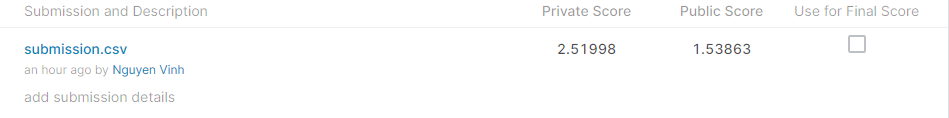

<p style="font-size:18px"> Kết quả submit sau khi sử dụng Voting Regressor. </p>

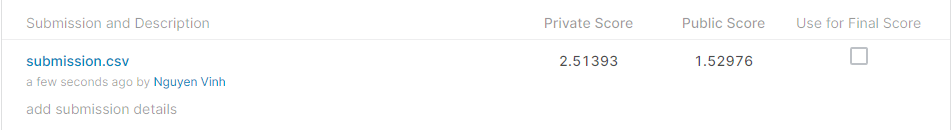

<p style="font-size:18px"> Như vậy, kết quả submit với Voting Regressor cao hơn một chút so với LightGBM Regressor.</p>

# 8. Tài liệu tham khảo
### [K- Fold Cross Validation For Parameter Tuning](https://medium.datadriveninvestor.com/k-fold-cross-validation-for-parameter-tuning-75b6cb3214f)
### [LightGBM with RandomizedSearchCV](https://www.kaggle.com/binilg/lightgbm-with-randomsearchcv-and-feature-imp)
### [Boosting](https://www.kaggle.com/fengdanye/machine-learning-7-boosting)
### [GradientBoosting](https://viblo.asia/p/gradient-boosting-tat-tan-tat-ve-thuat-toan-manh-me-nhat-trong-machine-learning-YWOZrN7vZQ0)
### [Hồi qui Ridge](https://phamdinhkhanh.github.io/deepai-book/ch_ml/RidgedRegression.html)